<a href="https://colab.research.google.com/github/Ppangchon/project/blob/main/mis55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModelOCT 

In [2]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import PIL
import plotly
import shutil
import plotly.graph_objs as go
import pandas as pd
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D)
import time
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
import requests
from IPython.display import Image
from io import BytesIO  
import pickle as p 
import plotly.graph_objs as go  
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
K.image_data_format()
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

## เตรียมชุดของข้อมูล

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์
path = '/content/drive/My Drive/lastoct'  # data เราอยู่โฟล์เดอร์ไหน

In [6]:
batch_size = 32   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 256  # ความสูงของรูปภาพแต่ละรูป
img_width = 256   # ความกว้างของรูปภาพแต่ละรูป

num_classes = 4

## Train

In [7]:
# Train
train_dir = "/content/drive/My Drive/lastoct/train"
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 17779 images belonging to 4 classes.


In [8]:
print('Train')
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนภาพของคลาส

Train
[0 1 2 3]
[4552 4469 4385 4373]


In [9]:
train_set[0][0][0].shape   # W*H*3 (3 Channel RGB) 

(256, 256, 3)

## Validation

In [10]:
# Validation
val_dir ="/content/drive/My Drive/lastoct/validation"
val_datagen = ImageDataGenerator(rescale = 1./255)

val_set = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 2217 images belonging to 4 classes.


In [11]:
print('Validation')
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)        # คลาส
print(counts)     # จำนวนข้อมูลของคลาส

Validation
[0 1 2 3]
[528 546 540 603]


## Test

In [12]:
# Test
test_dir ="/content/drive/My Drive/lastoct/test"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(img_height, img_width))

Found 2182 files belonging to 4 classes.


In [13]:
class_names = test_set.class_names
print(class_names)

['CSC', 'Normal', 'PCV', 'VKH']


## Training 

### สร้าง Model

In [14]:
num_classes = 4
epochs=10   # จำนวนครั้งที่เราจะ Train
# ขนาดภาพอินพุตเข้าสู่ Model
in_shape = (256,256,3)
in_shape

(256, 256, 3)

In [15]:
model = Sequential()   # สร้าง Model

# สร้างชั้น Convolution ชั้นแรก ค่าพารามิเตอร์ activation ใช้ ReLU
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = in_shape))
model.add(MaxPool2D((2,2)))    # สร้างชั้น Max Pooling ค่าพารามิเตอร์ 2,2 คือ Pool Size

# ชั้นที่ 2
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D((2,2)))

# ชั้นที่ 3 
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

# FULLY CONNECTED LAYER
model.add(Flatten())

# Output layer
model.add(Dense(4, activation='softmax')) # 4 คลาส
model.summary()          # ดูสรุปโครงสร้าง Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

##### ดู kernel

In [16]:
for layer in model.layers:
  if 'conv' not in layer.name:
       continue
  kernels, biases = layer.get_weights()
  print(layer.name, 'shape:', kernels.shape)

conv2d shape: (3, 3, 3, 16)
conv2d_1 shape: (3, 3, 16, 32)
conv2d_2 shape: (3, 3, 32, 64)


In [17]:
k_min, k_max = kernels.min(), kernels.max()
kernels = (kernels - k_min)/ (k_max - k_min)
kernel_idx = 0
kernel_i = kernels[:, :, 0, kernel_idx]
print(kernel_i.round(2))

[[0.31 0.53 0.69]
 [0.   0.15 0.33]
 [0.72 0.35 0.83]]


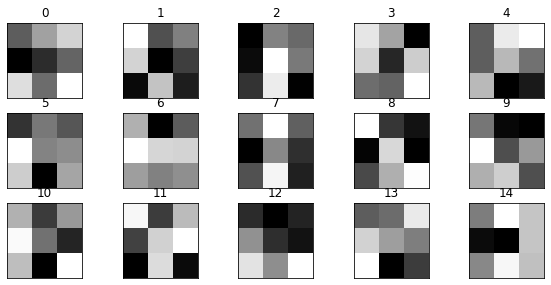

In [18]:
nplots = 15
fig = plt.figure(figsize = (10, 8))
for j in range(nplots):
  plt.subplot(5, 5, j+1)
  plt.imshow(kernels[:, :, 0, j], cmap = plt.cm.gray)
  plt.title(j)
  plt.xticks([]); plt.yticks([])
plt.show()

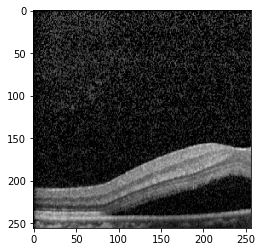

In [19]:
image = load_img('/content/drive/My Drive/trycode/train/CSC/IA3870 19-12-16 RE_000_cropped.png', target_size=(256, 256))
plt.imshow(image)
plt.show()

In [20]:
img1 = img_to_array(image)
print('shape =', img1.shape)
print('max pixel value =', np.max(img1))

shape = (256, 256, 3)
max pixel value = 240.0


### Compile และ Train

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
start = time.time()

history = model.fit(train_set, steps_per_epoch=len(train_set), 
                    validation_data=val_set, 
                    epochs=10,verbose=1)

end = time.time()
print("Time Taken: {:.2f} minutes".format((end-start)/60))

Epoch 1/10
556/556 [==============================] - 3622s 6s/step - loss: 1.0931 - accuracy: 0.5222 - val_loss: 1.1511 - val_accuracy: 0.5485
Epoch 2/10
556/556 [==============================] - 168s 302ms/step - loss: 0.5543 - accuracy: 0.7874 - val_loss: 1.2308 - val_accuracy: 0.6044
Epoch 3/10
556/556 [==============================] - 166s 299ms/step - loss: 0.3122 - accuracy: 0.8870 - val_loss: 1.1323 - val_accuracy: 0.6392
Epoch 4/10
556/556 [==============================] - 167s 300ms/step - loss: 0.1714 - accuracy: 0.9405 - val_loss: 1.0879 - val_accuracy: 0.6960
Epoch 5/10
556/556 [==============================] - 169s 303ms/step - loss: 0.0968 - accuracy: 0.9670 - val_loss: 1.3885 - val_accuracy: 0.7095
Epoch 6/10
556/556 [==============================] - 166s 299ms/step - loss: 0.0689 - accuracy: 0.9756 - val_loss: 1.6448 - val_accuracy: 0.6946
Epoch 7/10
556/556 [==============================] - 167s 300ms/step - loss: 0.0433 - accuracy: 0.9854 - val_loss: 1.9084 - v

### Save Model

In [23]:
with open('history_model', 'wb') as file:
   p.dump(history.history, file)

filepath='m_model.h5'
model.save(filepath)
filepath_model = 'm_model.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")
     

Saved model to disk


### Load Model

In [24]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['val_accuracy'],
mode="lines", line=dict(
width=2,
color='blue'),
name="val_accuracy"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testOCT")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## ประเมิน

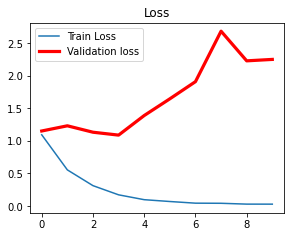

In [25]:
plt.figure(figsize = (10, 3.5))
plt.subplot(1, 2 , 1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], 'r', lw = 3.2, label = 'Validation loss')
plt.legend()

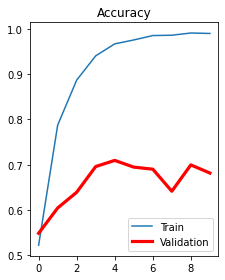

In [26]:
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], 'r', lw = 3.2, label = 'Validation')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
acc = model.evaluate(val_set, steps = len(val_set), verbose = 0)
print('score = {:.3f}' .format(acc[1]))

score = 0.682


### Prediction

In [28]:
import requests
from IPython.display import Image
from io import BytesIO
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing import image 
import keras.utils as image
from keras.models import load_model

In [29]:
train_set.class_indices

{'CSC': 0, 'Normal': 1, 'PCV': 2, 'VKH': 3}

1/1 [==============================] - 0s 199ms/step
CSC tf.Tensor(0.47536686, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


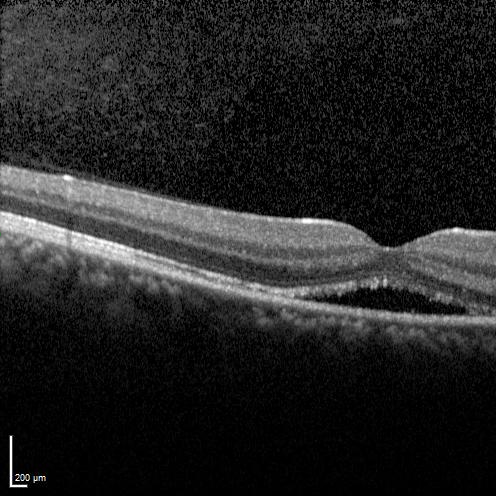

AI CSC มีความมั่นใจ 47.54%.


In [30]:
# CSC
test_path = ('/content/drive/My Drive/lastoct/test/CSC/GD7863 12-16-16 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.47536686, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


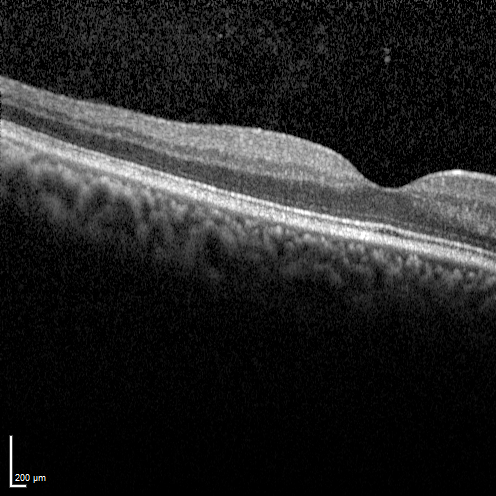

AI Normal มีความมั่นใจ 47.54%.


In [31]:
# Normal
test_path = ('/content/drive/My Drive/lastoct/test/Normal/CJ5901 24-01-19 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 21ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.47536686, shape=(), dtype=float32) VKH tf.Tensor(0.17487772, shape=(), dtype=float32)


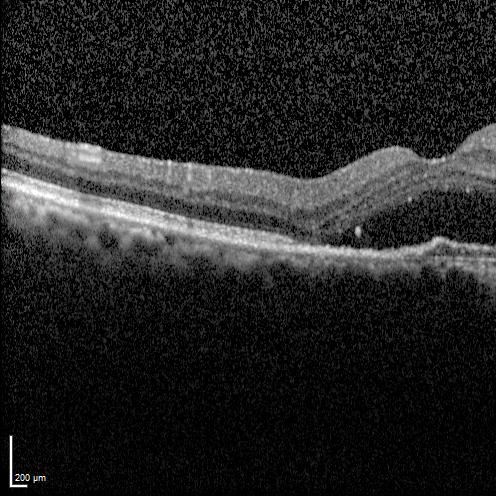

AI PCV มีความมั่นใจ 47.54%.


In [32]:
# PCV
test_path = ('/content/drive/My Drive/lastoct/test/PCV/AV0940 20-09-16 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
CSC tf.Tensor(0.17487772, shape=(), dtype=float32) Normal tf.Tensor(0.17487772, shape=(), dtype=float32) PCV tf.Tensor(0.17487772, shape=(), dtype=float32) VKH tf.Tensor(0.47536686, shape=(), dtype=float32)


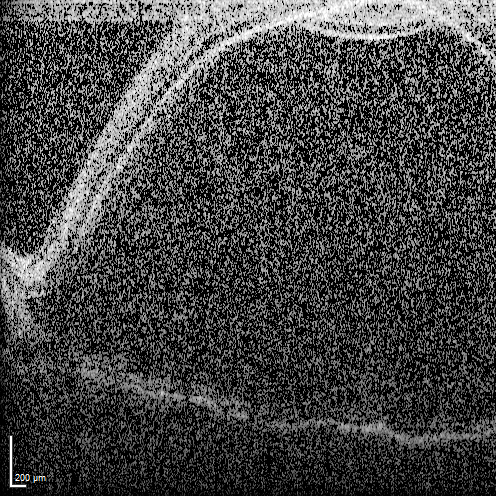

AI VKH มีความมั่นใจ 47.54%.


In [33]:
# VKH
test_path = ('/content/drive/My Drive/lastoct/test/VKH/KI2719 02-02-21 RE_000_cropped.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("CSC",score[0],"Normal",score[1],"PCV",score[2],"VKH",score[3])
display(Image(filename=test_path,width=256, height=256))
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(eye, 100 * np.max(score))
)

### Testing

In [34]:
test_set_ = test_set.unbatch()

In [35]:
#test_set.file_paths

In [36]:
import shutil

In [37]:
misclass_path = '/misclassify_model1'
if not os.path.exists(path+misclass_path):
    os.makedirs(path+misclass_path)

for myFilename in test_set.file_paths:

  tempfn = myFilename.split('/')
  myTrueVal = tempfn[6]
  mySubjID = tempfn[7].rstrip('_cropped.png')

  test_path = (myFilename)
  img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
    )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = predict_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if score[0]==np.max(score):
    eye = "CSC"
  elif score[1]==np.max(score):
    eye = "Normal"
  elif score[2]==np.max(score):
    eye = "PCV"
  elif score[3]==np.max(score):
    eye = "VKH"
  myConfid = np.round(100 * np.max(score),2)
  myPredVal = eye 

  if myTrueVal != myPredVal:
    fn = mySubjID+'__true-'+myTrueVal+'__pred-'+myPredVal+'__'+str(myConfid)+'.png'
    print(fn)
    shutil.copyfile(myFilename, path+misclass_path+'/'+fn)

1/1 [==============================] - 0s 18ms/step
DM7375 04-07-18 RE_001007__true-Normal__pred-VKH__47.54.png
1/1 [==============================] - 0s 19ms/step
GJ4350 16-11-15 RE_000023__true-CSC__pred-Normal__47.54.png
1/1 [==============================] - 0s 20ms/step
AY7496 08-31-17 RE_001008__true-PCV__pred-Normal__47.54.png
1/1 [==============================] - 0s 19ms/step
HI3742 18-07-17 RE_002017__true-CSC__pred-PCV__47.54.png
1/1 [==============================] - 0s 19ms/step
ED8056 05-05-17 LE_000010__true-Normal__pred-PCV__47.54.png
1/1 [==============================] - 0s 19ms/step
HI3742 18-07-17 RE_002002__true-CSC__pred-VKH__47.54.png
1/1 [==============================] - 0s 19ms/step
DL9765 25-05-18 LE_000006__true-Normal__pred-CSC__47.54.png
1/1 [==============================] - 0s 20ms/step
AV0940 21-08-18 LE_000021__true-PCV__pred-Normal__47.54.png
1/1 [==============================] - 0s 19ms/step
KN4858 21-02-22 RE_002005__true-VKH__pred-PCV__47.54.png
1

In [38]:
myFilename = '/content/drive/My Drive/lastoct/test/CSC/FQ8979 23-03-12 RE_000_cropped.png'

tempfn = myFilename.split('/')
myTrueVal = tempfn[6]
mySubjID = tempfn[7].rstrip('.png')

test_path = (myFilename)
img = keras.preprocessing.image.load_img(
  test_path, target_size=(img_height, img_width)
  )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
if score[0]==np.max(score):
  eye = "CSC"
elif score[1]==np.max(score):
  eye = "Normal"
elif score[2]==np.max(score):
  eye = "PCV"
elif score[3]==np.max(score):
  eye = "VKH"
myConfid = 100 * np.max(score)
myPredVal = eye 

print(myTrueVal, myPredVal, myConfid, mySubjID)

1/1 [==============================] - 0s 17ms/step
CSC CSC 47.536686062812805 FQ8979 23-03-12 RE_000_cropped


In [39]:
myImages = list(test_set_.map(lambda x, y: x))
myLabels = list(test_set_.map(lambda x, y: y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [40]:
print(len(myImages),len(myLabels))

2182 2182


In [41]:
y_test = []; y_pred = []
class_names = test_set.class_names
for images, labels in test_set:
  for i in range(len(list(labels))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "CSC"
    elif score[0][1]==np.max(score):
      eye = "Normal"
    elif score[0][2]==np.max(score):
      eye = "PCV"
    elif score[0][3]==np.max(score):
      eye = "VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]])

1/1 [==============================] - 0s 19ms/step


In [42]:
print(y_test)
print(len(y_test))

['PCV', 'CSC', 'PCV', 'Normal', 'VKH', 'PCV', 'CSC', 'CSC', 'VKH', 'Normal', 'PCV', 'CSC', 'CSC', 'CSC', 'PCV', 'VKH', 'CSC', 'PCV', 'PCV', 'Normal', 'Normal', 'CSC', 'Normal', 'VKH', 'Normal', 'PCV', 'CSC', 'Normal', 'CSC', 'VKH', 'VKH', 'Normal', 'Normal', 'PCV', 'CSC', 'CSC', 'VKH', 'VKH', 'CSC', 'Normal', 'PCV', 'VKH', 'Normal', 'Normal', 'Normal', 'CSC', 'Normal', 'Normal', 'CSC', 'CSC', 'CSC', 'CSC', 'PCV', 'Normal', 'CSC', 'Normal', 'VKH', 'PCV', 'CSC', 'VKH', 'Normal', 'VKH', 'VKH', 'Normal', 'CSC', 'PCV', 'Normal', 'VKH', 'PCV', 'Normal', 'CSC', 'VKH', 'CSC', 'PCV', 'PCV', 'CSC', 'VKH', 'PCV', 'VKH', 'Normal', 'PCV', 'Normal', 'Normal', 'PCV', 'VKH', 'CSC', 'PCV', 'VKH', 'PCV', 'CSC', 'CSC', 'Normal', 'CSC', 'Normal', 'VKH', 'VKH', 'VKH', 'CSC', 'Normal', 'CSC', 'PCV', 'Normal', 'VKH', 'PCV', 'PCV', 'PCV', 'PCV', 'VKH', 'Normal', 'CSC', 'VKH', 'PCV', 'Normal', 'CSC', 'Normal', 'VKH', 'PCV', 'VKH', 'VKH', 'CSC', 'VKH', 'PCV', 'VKH', 'VKH', 'CSC', 'PCV', 'PCV', 'PCV', 'Normal', 

In [43]:
print(y_pred)
print(len(y_pred))

['Normal', 'CSC', 'PCV', 'Normal', 'VKH', 'PCV', 'PCV', 'CSC', 'CSC', 'Normal', 'PCV', 'CSC', 'VKH', 'PCV', 'PCV', 'VKH', 'PCV', 'PCV', 'PCV', 'Normal', 'Normal', 'PCV', 'Normal', 'VKH', 'Normal', 'PCV', 'CSC', 'CSC', 'CSC', 'PCV', 'VKH', 'PCV', 'Normal', 'PCV', 'PCV', 'CSC', 'CSC', 'VKH', 'CSC', 'Normal', 'PCV', 'VKH', 'CSC', 'Normal', 'Normal', 'CSC', 'Normal', 'Normal', 'CSC', 'CSC', 'PCV', 'PCV', 'CSC', 'CSC', 'CSC', 'Normal', 'PCV', 'Normal', 'CSC', 'VKH', 'Normal', 'VKH', 'VKH', 'PCV', 'PCV', 'PCV', 'Normal', 'CSC', 'Normal', 'Normal', 'VKH', 'VKH', 'VKH', 'PCV', 'PCV', 'CSC', 'PCV', 'CSC', 'CSC', 'Normal', 'Normal', 'Normal', 'Normal', 'CSC', 'VKH', 'PCV', 'PCV', 'VKH', 'VKH', 'CSC', 'Normal', 'Normal', 'PCV', 'Normal', 'VKH', 'VKH', 'VKH', 'CSC', 'CSC', 'Normal', 'PCV', 'Normal', 'VKH', 'VKH', 'PCV', 'Normal', 'Normal', 'VKH', 'Normal', 'PCV', 'Normal', 'CSC', 'Normal', 'CSC', 'Normal', 'VKH', 'Normal', 'CSC', 'VKH', 'PCV', 'PCV', 'CSC', 'CSC', 'VKH', 'CSC', 'CSC', 'PCV', 'PCV'

In [44]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
confusion_matrix(y_test, y_pred)

array([[345,  79,  72,  56],
       [ 64, 468,  24,  14],
       [ 51,  78, 340,  59],
       [ 69,  27,  37, 399]])

In [46]:
cm = confusion_matrix(y_test, y_pred)

In [47]:
test_set.class_names

['CSC', 'Normal', 'PCV', 'VKH']

In [48]:
cm_df = pd.DataFrame(cm,
                     index = ['CSC', 'Normal', 'PCV', 'VKH'], 
                     columns = ['CSC', 'Normal', 'PCV', 'VKH'])

In [49]:
cm_df

,CSC,Normal,PCV,VKH
CSC,345,79,72,56
Normal,64,468,24,14
PCV,51,78,340,59
VKH,69,27,37,399


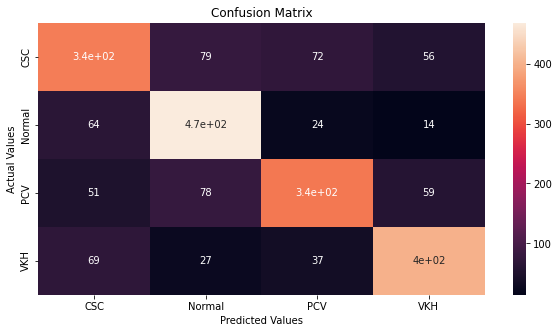

In [50]:
plt.figure(figsize=(10,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
     

## Confusion Matrix

#### ตัวชี้วัด

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [52]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.711274


In [53]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Recall: %f' % recall)

Recall: 0.711274


In [54]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('Precision: %f' % precision)

Precision: 0.710678


In [55]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted') ### ในส่วนของ average='weighted' หนูไม่มั่นใจว่าควรใส่เป็น macro, micro หรือ weight
print('F1 score: %f' % f1)

F1 score: 0.709497


##  misclassify

In [56]:
# แสดง misclassify ว่ามีกี่ค่า
misclassify = 0
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            misclassify += cm[i][j]
            
print('misclassification: ', misclassify)

misclassification:  630


In [57]:
# คำนวณค่า misclassification
misclassify = 1 - np.trace(cm) / np.sum(cm)

# Misclassification rate = จำนวนภาพที่ถูกจัดหมวดหมู่ผิด / จำนวนภาพทั้งหมดที่ใช้ในการทดสอบ

# แสดงผลลัพธ์ที่คิดเป็น %
print("Misclassification: {:.2f}%".format(misclassify*100))

Misclassification: 28.87%


## Grad-CAM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
model_builder = modelOCT.h5
img_size = (256, 256)
preprocess_input = keras.applications.model.preprocess_input
decode_predictions = keras.applications.model.decode_predictions

last_conv_layer_name = "conv2d_2"

# The local path to our target image
img_path = keras.utils.get_file(
    "GD7863 12-16-16 RE_000_cropped.png", "https://drive.google.com/drive/folders/1kDoCrxQysB-cYkoNWhaRlLHYBinCJmUg?fbclid=IwAR11QPijXyZPBb3MXD-n60vagilet0j6aX1Im48RQ391NM-hB95_EQ-Y6_E"
)

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Let's test-drive it

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
from tensorflow.keras.applications.xception import Xception

# สร้างโมเดล Xception
xception = Xception(weights='imagenet')

In [ ]:
# โหลดภาพ
img = load_img('/content/drive/My Drive/trycode/test/CSC/GD7863 12-16-16 RE_000_cropped.png', target_size=(299, 299))

# แปลงภาพเป็น numpy array
img_array = img_to_array(img)

# ปรับขนาดของภาพเพื่อเข้ากับ input shape ของโมเดล
img_resized = tf.image.resize(img_array, (299, 299))

# ปรับค่า pixel ของภาพตามที่ Xception คาดหวัง
img_preprocessed = preprocess_input(img_resized)

# ส่งภาพไปทำนายด้วยโมเดล Xception
predictions = xception.predict(np.array([img_preprocessed]))


In [ ]:
# Prepare image
img_path = "/content/drive/My Drive/trycode/test/CSC/GD7863 12-16-16 RE_000_cropped.png"
img = cv2.imread(img_path)
img_array = preprocess_input(get_img_array(img_path, size=img_size))# โหลดภาพและปรับขนาดภาพ

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Create a superimposed visualization


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
# โหลดโมเดลที่จะใช้สร้าง Class Activation Maps
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# สร้างโมเดลที่มี output เป็น class activation map
cam_model = tf.keras.Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output,  # feature maps
        model.layers[-1].output,  # output class probabilities
    ),
)

# คำนวณ Gradient ของค่า class ที่ต้องการ
grad_model = tf.keras.models.Model(
    inputs=model.input, outputs=model.layers[-4].output  # ตัวอย่างนี้เลือก layer ก่อนที่จะเข้า activation function
)

# วนลูปกลุ่มรูปภาพ
for image_path in image_paths:
    # โหลดรูปภาพ
    img = cv2.imread(image_path)

    # ปรับขนาดภาพให้เหมาะสมกับโมเดล
    img = cv2.resize(img, (224, 224))

    # ทำ forward pass เพื่อสร้าง feature maps
    features, results = cam_model.predict(np.array([img]))

    with tf.GradientTape() as tape:
        inputs = tf.cast(np.array([img]), tf.float32)
        tape.watch(inputs)
        feature_maps = grad_model(inputs)
        class_index = np.argmax(results)
        loss = feature_maps[:, :, :, class_index]
    grads = tape.gradient(loss, feature_maps)[0]

    # คำนวณค่าน้ำหนักเฉลี่ยของ Gradient
    weights = np.mean(grads, axis=(0, 1))

    # สร้าง Class Activation Map โดยใช้ Gradient และ Feature Maps
    cam = np.zeros(features.shape[1:3], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * features[0, :, :, i]

    # ปรับค่าของ CAM ให้อยู่ในช่วง 0-1 และปรับขนาดเท่ากับขนาดภาพเริ่มต้น
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    cam /= np.max(cam)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_img = heatmap * 0.5 + img * 0.5

    # แสดงภาพผลลัพธ์
    cv2.imshow('Grad-CAM', cam_img)
    cv2.waitKey()

In [ ]:
def grad_cam(model, img, layer_name):
    # หาค่า output และ gradient จากโมเดล
    output, grads = get_output_and_gradients(model, img, layer_name)
    
    # หาค่า weight ของโมเดล
    weights = np.mean(grads, axis=(0, 1, 2))

    # คำนวณ CAM โดยใช้ weight และ output ของโมเดล
    cam = np.zeros(output.shape[0:2]


In [ ]:
def get_output_and_gradients(model, img, layer_name):
    # สร้าง function ที่รับ input เป็นภาพและเป็น output ของชั้นที่ต้องการ
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    # สร้าง tensor ของ input
    img_tensor = tf.cast(img, tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    # หา output และ gradient จากโมเดล
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_output)

    # หาค่า weight โดยใช้ค่า gradient ที่มาจากหน้าที่ 1
    weights = tf.reduce_mean(grads, axis=(0, 1))
    weights = weights / tf.reduce_sum(weights)

    # หา weighted sum ของ output โดยใช้ weight
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)

    return cam, grads


In [ ]:
def visualize_cam(img, heatmap, alpha=0.5, cmap='jet'):
    # ทำ normalization ของ heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # ทำ resize ของ heatmap เพื่อให้มีขนาดเท่ากับภาพ
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # แปลง heatmap ให้เป็น RGB
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    # ผสม heatmap กับภาพต้นฉบับ
    img = np.uint8(img*255)
    cam = cv2.addWeighted(img, alpha, heatmap, 1-alpha, 0)

    return cam

def visualize_gradcam(model, img_path, layer_name):
    # โหลดภาพ
    img = cv2.imread(img_path)

    # ประมวลผลภาพด้วยโมเดล
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = tf.keras.applications.mobilenet_v2.preprocess_input(img_tensor)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    preds = model.predict(img_tensor)

    # สร้าง CAM
    cam, grads = grad_cam(model,img_tensor, layer_name)


In [ ]:
# แสดงผลภาพ
plt.figure(figsize=(10,10))

# แสดงภาพต้นฉบับ
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# แสดงภาพที่ผ่าน CAM
plt.subplot(1,2,2)
cam_img = visualize_cam(img, cam)
plt.imshow(cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')

plt.show()